# Smart home - topic modelling (LDA)
#### Source Data
2904 reddit comments form the subreddits **smarthome** and **homeautomation** extracted with [pushshift API](https://github.com/pushshift/api) using privacy, trust and security as query terms and size equal 500 (maximum allowed for each request). <br />

Here, topic modelling is used as exploratory/information retrieval tool to investigate what people are talking about when privacy, trust and security are involved. 


In [1]:
import json
import re
import warnings
from collections import Counter, defaultdict

import gensim
import gensim.corpora as corpora
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns
import spacy
import scipy.stats
from scipy.spatial import distance
from collections import OrderedDict
from bokeh.io import output_notebook
from bokeh.models import Label
from bokeh.plotting import figure, output_file, show
from gensim.models import CoherenceModel, LsiModel, HdpModel, LdaModel
from gensim.utils import simple_preprocess
from gensim.test.utils import datapath
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.manifold import TSNE
from wordcloud import STOPWORDS, WordCloud

## Run in terminal with the size wanted 
# python3 pushshift_comments.py 10

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# import training data

df = pd.read_csv('comments_query.csv', encoding='utf8')

# Cleaning up the comments
# nltk.download('stopwords')  # (run python console)
# nltk.download('wordnet')  # (run python console)
# python3 -m spacy download en  # (run in terminal)


## Pre-processing
- Strip out hyperlinks and copy thme in a new column URL
- Find all words with a hyphen between them and consider them as a unique word ('technical vocabulary')
- Remove common stop words
- Remove previous comments (copied text) within the comment
- Remove punctuation
- Remove digits
- Remvoe word that are less then 2 characters
- Keep only noun, adjectives, verbs and proper nouns
- Apply lemmantization

In [5]:
print(df.shape)
print(len(df['link_id'].unique()))

(2904, 9)
1604


In [634]:
# Extracting URLs: external links often informative, but they add unwanted noise to our NLP model
# Strip out hyperlinks and copy thme in a new column URL

# Find URL
def Find(string): 
    # with valid conditions for urls in string 
    url = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', string) 
    return url

# apply the function on the body column
df['URL'] = df.body.apply(Find)

# create a colummn with pre-processed:
df['clean_body'] = [re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', x) for x in df['body']]

In [635]:
# Find all internal hyphen words and consider them as full words ('technical vocabulary')
df['clean_body'] = [re.sub(r'([a-zA-Z]+)(-)([a-zA-Z]+)', r'\g<1>\g<3>', x) for x in df['clean_body']]

In [636]:
# Standardizing the informal language of comments
# NLTK Stop words
stop_words = stopwords.words('english')
stop_words.extend(['home', 'day', 'hour', 'minute', 'second', 'week', 'year', 'today', 'yesterday', 'tomorrow'])

#We specify the stemmer or lemmatizer we want to use
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
wordnet_lemmatizer = WordNetLemmatizer()

def clean_comment(comment, bigrams=False, lemma=False, allowed_postags=['NOUN', 'ADJ', 'VERB', 'PROPN']):
    comment = comment.lower() # ? consider to make general the name of companies or decives
    comment = re.sub('&gt', ' ', comment) # remove all copied text into a comment '&gt'
    comment = re.sub('[^\s\w]', ' ', comment) # strip out everything (punctuation) that is not Unicode whitespace or word character
    comment = re.sub('[0-9]+', ' ', comment) # remove digits

    # remove stop_words
    comment_token_list = [word for word in comment.strip().split() if word not in stop_words]
    
    # remove one character word
    comment_token_list = [word for word in comment_token_list if len(word) > 1]
    
    # keeps word meaning
    if lemma == True:
        # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
        nlp = spacy.load('en', disable=['parser', 'ner'])
        # https://spacy.io/api/annotation
        comment_text = nlp(' '.join(comment_token_list))
        comment_token_list = [token.lemma_ for token in comment_text if token.pos_ in allowed_postags]
        #comment_token_list = [wordnet_lemmatizer.lemmatize(word) for word in comment_token_list]
    
    # harsh to the root of the word
    else:
        comment_token_list = [word_rooter(word) for word in comment_token_list]

    if bigrams:
        comment_token_list = bigram[comment_token_list]
    
    comment = ' '.join(comment_token_list)
    
    return comment

In [637]:
# Apply function to clean the comment
# Takes long time to run

import time

start = time.time()
df['clean_body'] = df.clean_body.apply(clean_comment, lemma=True)
end = time.time()
print(end - start)


1705.6942760944366


In [162]:
# print(df['body'][500])
# print('\n\n')
# df['clean_body'][2].strip().split()
# df[df["clean_body"].str.lower().str.contains("em")]

In [163]:
# nlp = spacy.load('en', disable=['parser', 'ner'])
# bar = 'People will eventually start talking about em privacy'.strip().split()
# foo = nlp(' '.join(bar))
# for i in foo:
#    print(i, '\t', i.pos_, '\t', i.lemma_)
    
# 'compromise' in stop_words

In [192]:
# function to plot most frequent terms or vice versa
def freq_words(x, ascending=False, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = nltk.FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top most frequent words
  d = words_df.sort_values("count", ascending=ascending)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d[:terms], x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.xticks(rotation=45)
  plt.show()

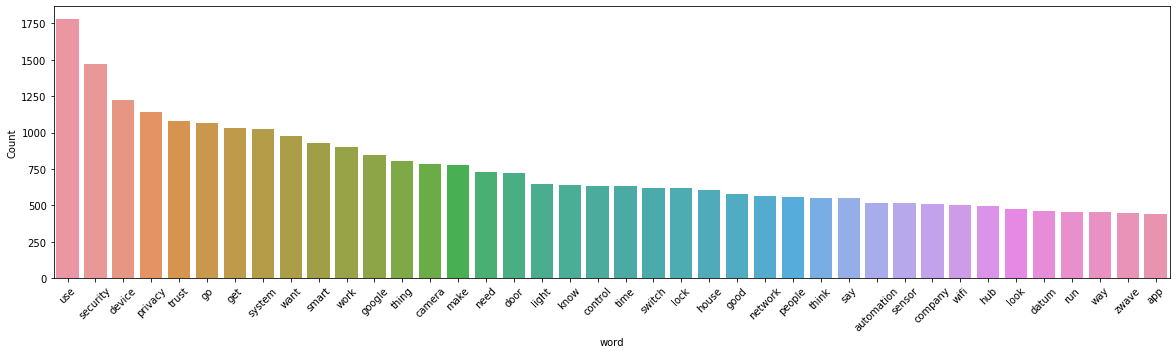

In [200]:
freq_words(df['clean_body'], False, 40)

In [194]:
def comment2token(comments):
    '''
    Return sequence (stream, generator) of sentences,
    with each sentence a list of tokens
    '''
    return [comment.split() for comment in comments]

comment_token_list = comment2token(df['clean_body'])

# Train Bigram and Trigram Models
# higher threshold fewer phrases.
bigram = gensim.models.Phrases(comment_token_list, min_count=20, threshold=300)

# Frequency of n-gram words
dist = nltk.FreqDist(
    [word for comment in bigram[comment_token_list] for word in comment if '_' in word])

# Sort frequency
print('Sorted trigrams: \n')
print(sorted(dist.items(), key=lambda x: x[1], reverse=True))
print('-'*20)

Sorted trigrams: 

[('third_party', 42), ('raspberry_pi', 40), ('_', 40), ('blue_iris', 29), ('person_in_address_book', 1), ('info_we_collect', 1), ('tp_link', 1), ('domain_comvrsn', 1), ('amzn_ssid', 1), ('amzn_pw', 1), ('lemon_tea', 1), ('not_home', 1), ('eternal_peril', 1), ('automate_the_thing', 1), ('ok_hand', 1), ('t_d', 1)]
--------------------


In [198]:
# df[df["clean_body"].str.lower().str.contains("")]

In [199]:
# Create a new columns with tokens
df['token_text'] = [[word for word in comment.split()] for comment in df['clean_body']]

In [10]:
# Add Wikipedia corpus
#with open('train_wiki.json', 'r') as f:
#    train_wiki = json.load(f)

#link = []
#category = []
#body_par = []

#for item in train_wiki:
#    link.append(item['link'])
#    category.append(item['category'])
#    body_par.append(item['body_par'])

# wiki_text= []
# for elm in body_par:
#     wiki_text.append(' '.join(elm))

# wiki_text = pd.DataFrame({'wiki_text': wiki_text})

# # Apply function to clean the comment
# wiki_text['wiki_clean'] = wiki_text.wiki_text.apply(clean_comment, lemma=True)
# wiki_text['token_text'] = [[word for word in comment.split()] for comment in wiki_text['wiki_clean']]

In [201]:
comment = df['token_text']
# comment = pd.concat([wiki_text['token_text'], df['token_text']], ignore_index=True)

In [202]:
# Create Dictionary
dictionary = corpora.Dictionary(comment)

# Term Document Frequency >> (id, freq) for each page
corpus = [dictionary.doc2bow(text) for text in comment]

# print('\nPrint words and frequencies in the first comment:\n')
# print([[(dictionary[id], freq) for id, freq in page] for page in corpus[3:4]])
# print('-' * 20)

## TF-IDF
TF-IDF scores the relative importance of words. It is used as pre-processing step to check if there are other words that should be deleted. <br />

$w_{i,j} = tf_{i,j} * log(\frac{N}{df_{i}})$

- Small score: words commonly used across all documents and rarely used in the particular document
- Large score: words that appear frequently in a particular document, but not often in the corpus.


Small tfidf:

vacuums: 0.03328732097497261
landscaping: 0.03328732097497261
hourlong: 0.03328732097497261
cradle: 0.03328732097497261
mailman: 0.03328732097497261
ringer: 0.03328732097497261
preparation: 0.03328732097497261
offtime: 0.03328732097497261
awake: 0.03328732097497261
tracked: 0.03328732097497261

Large tfidf:

close: 1.0
security: 1.0
trust: 1.0
follow: 1.0
homekitprivacy: 1.0
upgrade: 1.0
hah: 0.9701651680907885
rating: 0.9609096452151494
film: 0.9609067018243865
weak: 0.9471942181208346


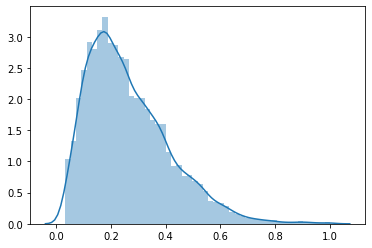

In [203]:
# TF-IDF model as pre-processing step
cv = CountVectorizer()
comment_token_vector = cv.fit_transform(df['clean_body'])
# comment_token_vector = cv.fit_transform(pd.concat([wiki_text['wiki_clean'],
#                                                    df['clean_body']], ignore_index=True))

# Compute the IDF values
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(comment_token_vector)

# Compute the TFIDF score (new unseen dataset)
count_vector = cv.transform(df['clean_body'])
tfidf_vector = tfidf_transformer.transform(count_vector)

# Check if it makes sense
feature_names = np.array(cv.get_feature_names())

# Remove the words that do not appear in the unseen dataset
zero_index = np.where(tfidf_vector.max(0).toarray()[0] == 0)[0]
feature_names = np.delete(feature_names, zero_index)
tfidf_vector = np.delete(tfidf_vector.max(0).toarray()[0], zero_index)

# max(0) equal max by columns
# argsort: return the indices that would sort an array
# sorted_tfidf_index = tfidf_vector.max(0).toarray()[0].argsort()
sorted_tfidf_index = tfidf_vector.argsort()

# Small: words commonly used across all documents and rarely used 
# in the particular document/low frequency term 
print('Small tfidf:\n')
for i in sorted_tfidf_index[:10]:
    print('{}: {}'.format(feature_names[i],
                                           tfidf_vector[i]))
# Large: Term that appears frequently in a particular document, but not often in the corpus.
print('\nLarge tfidf:\n')
for i in sorted_tfidf_index[:-11:-1]:
    print('{}: {}'.format(feature_names[i],
                                           tfidf_vector[i]))
    
sns.distplot(tfidf_vector)
# CONSIDER: find score threshold where words are deleted

In [623]:
# Find the optimal number of topics
def LdaMallet_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 3):
    '''
    Compute c_v coherence for various number of topics
    
    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input texts
    limit: max num of topics
    
    Returns:
    ---------
    model_list: list of LDA topic models
    coherence_values: corresponding to the LDA model
    '''
    
    mallet_path = 'mallet-2.0.8/bin/mallet'
    
    coherence_values = []
    model_list = []

    for num_topics in range(start, limit, step):
        print('Running model with number of topics: ', num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus = corpus, num_topics = num_topics, id2word = dictionary)
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

def LDA_coherence_values(dictionary, corpus, texts, num_topics_list): #start=2, step=3
    '''
    Compute c_v coherence for various number of topics

    Parameters:
    ---------
    dictionary: Gensim dictionary
    corpus: Gensim corpus
    texts: list of input text 
    chunksize: number of documents to be used in each training chunk
    limit: max num of topics

    Returns:
    ---------
    model_list: list of LDA topic
    coherence_values: corresponding to the LDA model
    '''

    coherence_values = []
    model_list = []

    for num_topics in num_topics_list: #range(start, limit, step):
        print('Running model with number of topics: ', num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary,
                                                num_topics=num_topics, random_state=100, 
                                                update_every=1, chunksize=100, passes=10, 
                                                alpha='auto', per_word_topics=True)
        
        model_list.append(model)

        coherencemodel = CoherenceModel(model = model, texts = texts, dictionary = dictionary, coherence = 'c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

## LDA
The observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model. 

![title](Smoothed_LDA.png)

$M$ denotes the number of documents<br />
$N$ is number of words in a given document (document $i$ has $N_{i}$ words)<br />
$K$ denotes the number of topics<br />
$α$ is the parameter of the Dirichlet prior on the per-document topic distributions<br />
$β$ is the parameter of the Dirichlet prior on the per-topic word distribution<br />
$θ_{i}$ is the topic distribution for document $i$<br />
$φ_{k}$ is the word distribution for topic $k$<br />
$z_{i,j}$ is the topic for the j-th word in document $i$<br />
$w_{i,j}$ is the specific word.<br />

The total probability of the model is:<br />
$P(W,Z, θ, φ, α, β) = \prod_{k=1}^{K} P(φ_{k};β)\prod_{i=1}^{M} P(θ_{i};α)\prod_{j=1}^{N} P(z_{i,j}|θ_{i})P(w_{i,j}|φz_{i,j})$

In [626]:
model_list, coherence_values = LDA_coherence_values(dictionary=dictionary, corpus=corpus, 
                                                    texts=comment,
                                                    num_topics_list = [5, 10, 50, 80, 100, 150]) #start=100, limit=300, step=10

Running model with number of topics:  5
Running model with number of topics:  10
Running model with number of topics:  50
Running model with number of topics:  80
Running model with number of topics:  100
Running model with number of topics:  150


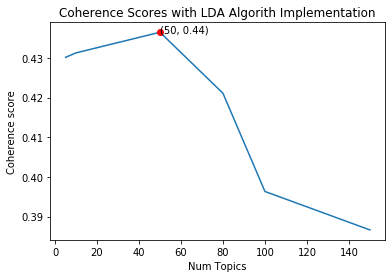

In [627]:
x = [5, 10, 50, 80, 100, 150]
plt.plot(x, coherence_values)
plt.plot(x[np.argmax(coherence_values)], max(coherence_values), 'or')
plt.text(x[np.argmax(coherence_values)]+0.2, max(coherence_values), 
         r'({}, {})'.format(x[np.argmax(coherence_values)], np.round(max(coherence_values), 2)))
plt.xlabel('Num Topics')
plt.ylabel('Coherence score')
plt.title('Coherence Scores with LDA Algorith Implementation')
# plt.savefig('output/Topics_Coher_LDA_Model_page')
plt.show()

In [628]:
print('\nLDA model: \n')
for num, cv in zip(x, coherence_values):
    print('Nun Topics =', num, ' has Coherence Value of', round(cv, 4))
print('-'*20)


LDA model: 

Nun Topics = 5  has Coherence Value of 0.4302
Nun Topics = 10  has Coherence Value of 0.4313
Nun Topics = 50  has Coherence Value of 0.4365
Nun Topics = 80  has Coherence Value of 0.4211
Nun Topics = 100  has Coherence Value of 0.3963
Nun Topics = 150  has Coherence Value of 0.3867
--------------------


In [367]:
# Extract the model base on the topic number
def model_extract(num_topics):
    '''
    Input: num_topics (int)
    '''
    # get number of topics
    num, _ = zip(*list(zip(x,coherence_values)))
    model = model_list[[i for i in range(len(num)) if num[i] == num_topics][0]]
    
    return model

model = model_extract(100)

In [334]:
# save model to disk
temp_file = datapath("query_comm35_5_50_5")
model.save(temp_file)
# Load a potentially pretrained model from disk.
# lda = LdaModel.load(temp_file)

In [368]:
model_topics = model.show_topics(num_topics=100, num_words=10,formatted = False)

In [369]:
print('\n LDA topics: \n')
for topic, keyword in model.print_topics(num_words=10):
    print('Topic: ', topic)
    print('Keywords: ', keyword)
print('-'*20)


 LDA topics: 

Topic:  47
Keywords:  0.000*"integrator" + 0.000*"taint" + 0.000*"matrix" + 0.000*"pre" + 0.000*"splice" + 0.000*"strand" + 0.000*"unfinished" + 0.000*"park" + 0.000*"patrol" + 0.000*"flipping" + 0.000*"media" + 0.000*"crooks" + 0.000*"exchangeable" + 0.000*"occurring" + 0.000*"suppress" + 0.000*"trap" + 0.000*"enrollment" + 0.000*"heos" + 0.000*"enrol" + 0.000*"participate"
Topic:  15
Keywords:  0.000*"integrator" + 0.000*"taint" + 0.000*"matrix" + 0.000*"pre" + 0.000*"splice" + 0.000*"strand" + 0.000*"unfinished" + 0.000*"park" + 0.000*"patrol" + 0.000*"flipping" + 0.000*"media" + 0.000*"crooks" + 0.000*"exchangeable" + 0.000*"occurring" + 0.000*"suppress" + 0.000*"trap" + 0.000*"enrollment" + 0.000*"heos" + 0.000*"enrol" + 0.000*"participate"
Topic:  57
Keywords:  0.000*"integrator" + 0.000*"taint" + 0.000*"matrix" + 0.000*"pre" + 0.000*"splice" + 0.000*"strand" + 0.000*"unfinished" + 0.000*"park" + 0.000*"patrol" + 0.000*"flipping" + 0.000*"media" + 0.000*"crooks" +

### LDAvis graph interpretation
Output: probability mass function over the words in the model for each topic. <br />

*ON THE RIGHT SIDE*:<br />
Horizontal bars: list top 30 words given the topic.<br />
Red horizontal bars: frequency of each words given a topic.<br />
Gray horizontal bars: overall word frequency.<br />

Lowering the parameter lambda put more weight on the ration red to gray, thus you can see the 'jargon' specific to the topic (this improve readability for those who are not familiar with the topic).<br />

Going with the mouse over the words of the bars, you can visualize the unexplained portion of a word within the topics (thus see which other topics are using the word).<br />

*ON THE LEFT SIDE*:<br />
The distance between the topics in the scatter plot is an approximation of the difference between topics and their semantic relationship. It approximates the original topic similarity matrix with dimensions $\frac{(num\_topics - 1)^{num\_topics}}{2}$. Multidimensional scaling dows its best to preserve the original distance. <br />

The bubble size is the topic prevalence.<br />

The indice inside the bubbles is the sorted order by area, 1 being the most popular topic.<br />


In [620]:
# Visualize the topics
# Takes a lot of time to run
# mds='TSNE'
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary, mds='TSNE')
vis


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
72      55.979290 -111.783745       1        1  10.421618
3       -2.369633  143.139771       2        1   4.922171
5        3.452825  -80.711006       3        1   4.303530
4      178.396957  -45.243305       4        1   4.099875
67     -53.592953   23.269730       5        1   3.495027
...           ...         ...     ...      ...        ...
57      18.574800  -36.440533      96        1   0.006088
56      28.346619   -0.872990      97        1   0.006088
82      16.381117   -8.802934      98        1   0.006088
81      43.377934    2.579468      99        1   0.006088
46      38.213959  -13.245874     100        1   0.006088

[100 rows x 5 columns], topic_info=      Category         Freq         Term        Total  loglift  logprob
151    Default  2666.000000        trust  2666.000000  30.0000  30.0000
197    Default  1515.000000     security  1515.000000  29.0000  29.0000
226    Default  1757.000000          get  1757.000000  28.0000  28.0000
43     Default  2450.000000          use  2450.000000  27.0000  27.0000
81     Default  1279.000000       system  1279.000000  26.0000  26.0000
...        ...          ...          ...          ...      ...      ...
3123  Topic100     0.000847     selfless     1.061454   2.5728  -9.1398
3122  Topic100     0.000847  prosecution     1.061454   2.5728  -9.1398
3120  Topic100     0.000847      consent     1.061454   2.5728  -9.1398
3113  Topic100     0.000847         used     1.061454   2.5728  -9.1398
3119  Topic100     0.000847    authorize     1.061454   2.5728  -9.1398

[4985 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
290       1  0.992044   ability
528      61  0.994811      able
970      73  0.749127  absolute
291       6  0.986203    access
291      15  0.011882    access
...     ...       ...       ...
374      12  0.959241      year
818      14  0.927244       zee
501      43  0.993645    zigbee
1515     44  0.978674      zone
241      24  0.998863     zwave

[1095 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[73, 4, 6, 5, 68, 56, 63, 25, 50, 70, 27, 20, 92, 62, 26, 1, 53, 89, 36, 97, 9, 80, 93, 24, 49, 22, 3, 10, 43, 38, 69, 17, 84, 11, 40, 52, 94, 90, 74, 8, 75, 87, 30, 72, 19, 65, 51, 66, 98, 54, 42, 35, 34, 71, 23, 86, 59, 29, 55, 45, 60, 61, 67, 79, 21, 37, 7, 81, 28, 64, 14, 13, 46, 2, 44, 39, 78, 31, 95, 33, 85, 88, 76, 96, 41, 100, 77, 99, 15, 16, 12, 18, 48, 91, 32, 58, 57, 83, 82, 47])

In [423]:
# Extract the topic with highest security, trust and privacy

def relevent_topic(num_topics, query):
    '''
    Input:
        > num_topics: integer
        > query: term string
    '''
    print('{} topics:\n'.format(query.upper()))
    relevant = [(num, dist) for num, dist in model.show_topics(num_words=10, num_topics = num_topics) if len(re.findall(query, dist)) != 0]
    
    for i in relevant:
        print('Topic: {}'.format(i[0]))
        print('Distribution: {}\n'.format(i[1]))

        
def target_topics(num_topics, query_list):
    target_topics = []
    for i in query_list:
        relevant = [(num, dist) for num, dist in model.show_topics(num_words=10, num_topics = num_topics) if len(re.findall(i, dist)) != 0]
        for j in relevant:
            target_topics.append(j[0])
    
    return target_topics
        

In [415]:
relevent_topic(100, 'security')
relevent_topic(100, 'privacy')
relevent_topic(100, 'trust')

SECURITY topics:

Topic: 16
Distribution: 0.548*"lock" + 0.144*"secure" + 0.079*"hack" + 0.055*"separate" + 0.030*"disable" + 0.024*"vulnerability" + 0.021*"compromise" + 0.011*"hardwire" + 0.003*"surprise" + 0.000*"smart" + 0.000*"open" + 0.000*"security" + 0.000*"dumb" + 0.000*"person" + 0.000*"flipping" + 0.000*"media" + 0.000*"unfinished" + 0.000*"park" + 0.000*"innocuous" + 0.000*"patrol"

Topic: 49
Distribution: 0.493*"security" + 0.113*"enough" + 0.112*"provide" + 0.072*"consider" + 0.044*"storage" + 0.029*"stream" + 0.027*"avoid" + 0.025*"traffic" + 0.020*"remember" + 0.005*"bandwidth" + 0.003*"recorder" + 0.000*"network" + 0.000*"help" + 0.000*"suppress" + 0.000*"media" + 0.000*"crooks" + 0.000*"flipping" + 0.000*"park" + 0.000*"trap" + 0.000*"exchangeable"

PRIVACY topics:

Topic: 35
Distribution: 0.453*"google" + 0.207*"assistant" + 0.136*"voice" + 0.029*"siri" + 0.021*"child" + 0.019*"significant" + 0.018*"enjoy" + 0.018*"logic" + 0.011*"flexibility" + 0.001*"minimize" + 0.

[3, 51]

In [372]:
# Find the dominant topic in each sentence
# Find the topic number with the highest percentage contribution in that document

def dominant_topic(ldamodel, corpus, texts):
    # init dataframe
    topics_df = pd.DataFrame()

    # GET MAIN TOPIC IN EACH WEBPAGE
    # Get throught the pages
    for num, page in enumerate(ldamodel[corpus]):
        # Count number of list into a list
        if sum(isinstance(i, list) for i in page)>0:
            page = page[0]

        page = sorted(page, key= lambda x: (x[1]), reverse=True)
    
        for j, (topic_num, prop_topic) in enumerate(page):
            if j == 0: # => dominant topic
                # Get list prob. * keywords from the topic
                pk = ldamodel.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in pk])
                # Add topic number, probability, keywords and original text to the dataframe
                topics_df = topics_df.append(pd.Series([int(topic_num), np.round(prop_topic, 4),
                                                    topic_keywords, texts[num]]),
                                                    ignore_index=True)
            else:
                break
                
    # Add columns name
    topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'Text']

    return topics_df


In [373]:
target_corpus = [dictionary.doc2bow(text) for text in df['token_text']]

In [448]:
dominant_df = dominant_topic(model, target_corpus, df['body'])
dominant_df.head(10)

,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text
0,72.0,0.2805,"use, work, make, good, know, way, app, little,...","Not sure if you're going for humor, or just be..."
1,72.0,0.1005,"use, work, make, good, know, way, app, little,...",Are you commenting from your smart phone? Beca...
2,72.0,0.1089,"use, work, make, good, know, way, app, little,...",People will eventually start talking about EM ...
3,19.0,0.1202,"year, end, interest, worth, show, party, life,...",My suggestion is just don’t use voice assistan...
4,72.0,0.0968,"use, work, make, good, know, way, app, little,...","There's an open source version, if you're a te..."
5,52.0,0.1321,"door, window, unlock, front, panel, location, ...",Get hard wired sensors for all doors and windo...
6,72.0,0.1588,"use, work, make, good, know, way, app, little,...",It is NOT for additional privacy. It is for...
7,8.0,0.2311,"alarm, keep, question, post, mention, suggest,...",This is a company account. We're not trying to...
8,72.0,0.0961,"use, work, make, good, know, way, app, little,...","If you care about your privacy, the answer is ..."
9,72.0,0.0917,"use, work, make, good, know, way, app, little,...",You might consider Alarm.com in conjunction wi...


In [375]:
# Find the most representative document for each topic in order to infer the topic
ref_document = pd.DataFrame()
df_topic_grouped = dominant_df.groupby('Dominant_Topic')

for i, grp in df_topic_grouped:
    # populate the sorted dataframe with the page that contributed the most to the topic
    ref_document = pd.concat([ref_document, grp.sort_values(['Perc_Contribution'], ascending = [0]).head(1)], axis = 0)
    
# Reset Index and change columns name
ref_document.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

ref_document.head(20)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
65,0.0,0.2062,"buy, nest, thermostat, integrate, integration,...",I had the nest learning thermostat for the la...
2828,2.0,0.1646,"wire, many, mind, hand, backup, shut, ethernet...",Last week I also attempted to follow the direc...
10,3.0,0.2099,"trust, company, product, see, customer, put, l...",I personally trust Apple more. But I’m still u...
68,4.0,0.2102,"time, need, take, much, code, possible, help, ...",How much work do you want to put into it? You...
20,5.0,0.2612,"get, go, want, say, new, less, email, activate...","I was gonna say, this must be a new policy. \n..."
1760,7.0,0.0835,"link, list, idea, can, cool, pi, return, gatew...","You can the case, desolder a bad capacitor, an..."
7,8.0,0.2311,"alarm, keep, question, post, mention, suggest,...",This is a company account. We're not trying to...
62,9.0,0.1583,"well, amazon, option, pro, prefer, recommend, ...",I'm in the same boat. I'm specifically wonderi...
1712,10.0,0.1040,"internet, cloud, local, speed, additional, pro...",That’s why I have only some devices on auto up...
2223,16.0,0.1236,"lock, secure, hack, separate, disable, vulnera...",Yeah. Almost any scenario where an intruder wo...


In [ ]:
#print(df['body'][44])
#print('\n\n')
#print(df['clean_body'][44])


## Jensen-Shannon Distance
A measure that we can use to find the similarity between the two probability distributions. 0 indicates that the two distributions are the same, and 1 would indicate that they are nowhere similar.

$JSD(P||Q)=\sqrt{\frac{D(P||M)+D(Q||M)}{2}}$

Where P & Q are the two probability distribution, M = (P+Q)/2, and D(P||M) is the KLD between P and M. Similarly D(Q||M) is the KLD between Q and M.

In [380]:
# Calculate Jensen-Shannon distance between two probability distributions using scipy.stats.entropy.
# Create Document - Topic Matrix

# column names
topicnames = ["Topic" + str(i) for i in range(len(model.print_topics(num_topics=100)))]

# index names
docnames = ["Doc" + str(i) for i in range(df.shape[0])]

# Make the pandas dataframe
doc_topic = pd.DataFrame(columns=topicnames, index=docnames)

# Populate the matrix with topic probability distribution for a document
for doc_num, dist in enumerate(model[target_corpus]):
    for i in dist[0]:
        doc_topic.iloc[doc_num,i[0]] = i[1]

doc_topic = doc_topic.fillna(0)

# # Styling
# def color_green(val):
#     color = 'green' if val > .1 else 'black'
#     return 'color: {col}'.format(col=color)

# def make_bold(val):
#     weight = 700 if val > .1 else 400
#     return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
# doc_topic_vis = doc_topic.style.applymap(color_green).applymap(make_bold)




In [385]:
doc_topic[:3]

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic90,Topic91,Topic92,Topic93,Topic94,Topic95,Topic96,Topic97,Topic98,Topic99
Doc0,0.011360,0.0,0.00000,0.047167,0.031045,0.046877,0.0,0.0,0.000000,0.000000,...,0,0.010388,0.028533,0.0,0,0,0.029905,0.0,0,0
Doc1,0.012012,0.0,0.00000,0.049877,0.032828,0.035001,0.0,0.0,0.010321,0.010145,...,0,0.010985,0.030173,0.0,0,0,0.012466,0.0,0,0
Doc2,0.013009,0.0,0.01044,0.054015,0.035552,0.058651,0.0,0.0,0.011178,0.010987,...,0,0.011896,0.032676,0.0,0,0,0.034247,0.0,0,0


In [408]:
# # Make the pandas dataframe
# js_matrix = pd.DataFrame(columns=np.array(range(df.shape[0])), index=np.array(range(df.shape[0])))

# for i in range(js_matrix.shape[0]):
#     for j in range(js_matrix.shape[0]):
#         js_matrix.iloc[i,j] = distance.jensenshannon(doc_topic.iloc[i,:], doc_topic.iloc[j,:])

# DOCUMENT BY DOCUMENT JENSENSHANNON CALCULATION
# dictionary implementation
js_dict = {}

for r in np.array(range(df.shape[0])):
    for c in np.array(range(df.shape[0])):
        if c <= r:
            pass
        else:
            js_dict[str(r)+'-'+str(c)] = distance.jensenshannon(doc_topic.iloc[r,:], doc_topic.iloc[c,:])



In [543]:
# Get reference document by topic and the related ones top 3 for topics of interest

for i in target_topics:
    print('\nTopic', i)
    doc_index = ref_document.index[ref_document['Topic_Num'] == i][0]
    print('Keywords:', ref_document.loc[doc_index, 'Keywords'])
    print('Reference comment:', doc_index)
    print('Link: https:www.reddit.com{}'.format(df['permalink'][doc_index]))
    new = {}
    for j in [k for k in js_dict.keys()]:
        # Extract the key's values with the document
        if str(doc_index) in np.array(re.findall('(\d*)-(\d*)', j)[0]):
            new[j] = js_dict[j]
    # subset for documents with js under threshold
    # new = dict((k, v) for k, v in new.items() if v < 0.4)
    # sort turn a dictionary to a list of tuple
    new = sorted(new.items(), key=lambda x: x[1], reverse=False)
    # Extract the top 3
    new = new[:3]
    print('Related comments: ')
    for docs, val in new:
        # extract document number different from reference document
        num = re.findall('(\d*)-(\d*)', docs)[0]
        j = [j for j in num if j != str(doc_index)][0]
        print('Document: ', j)
        print('JSD score: ', val)
        print('https:www.reddit.com{}'.format(df['permalink'][int(j)]))
    #related_comments = np.where((js_matrix.iloc[doc_index] < 0.1) &
    #                            (js_matrix.index != doc_index))[0]
    #print('Related comments: ')
    #for j in related_comments:
    #    print('https:www.reddit.com{}'.format(df['permalink'][j]))
        



Topic 16
Keywords: lock, secure, hack, separate, disable, vulnerability, compromise, hardwire, surprise, smart
Reference comment: 2223
Link: https:www.reddit.com/r/homeautomation/comments/blubx0/psa_dont_put_your_google_homealexa_near_a_window/emuxcya/
Related comments: 
Document:  398
JSD score:  0.3825854704744986
https:www.reddit.com/r/homeautomation/comments/bfrefo/additional_smart_lock_or_automation_for_pool/elg48gp/
Document:  1488
JSD score:  0.3882843651934424
https:www.reddit.com/r/homeautomation/comments/d57eoq/we_bought_this_at_costco_my_bro_in_law_came_home/f0lig28/
Document:  2024
JSD score:  0.38927500751913496
https:www.reddit.com/r/homeautomation/comments/df7gec/why_is_that_is_it_really_so_easy_to_hack_in_or/f326dgp/

Topic 49
Keywords: security, enough, provide, consider, storage, stream, avoid, traffic, remember, bandwidth
Reference comment: 38
Link: https:www.reddit.com/r/homeautomation/comments/dudb0j/in_need_of_internet_solution_to_cover_huge_indoor/f77bm09/
Relat

In [570]:
# How much topics related to each other?

# Make the pandas dataframe
topics_dictionary = pd.DataFrame(columns=np.array(range(len(dictionary))), index=target_topics)

# Populate the matrix with word probability distribution for a topic
for i in target_topics:
    word_prob = model.get_topic_terms(i, topn=len(dictionary))
    for j in word_prob:
        topics_dictionary.loc[i, j[0]] = j[1]

topics_dictionary = topics_dictionary.fillna(0)

#list(map(set,topics_dictionary.values))
topics_dictionary

,0,1,2,3,4,5,6,7,8,9,...,9309,9310,9311,9312,9313,9314,9315,9316,9317,9318
16,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,...,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009,0.000009
49,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,...,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006
35,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,...,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010,0.000010
92,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.232484,...,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023,0.000023
3,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,...,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
51,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011


In [572]:
# Make the pandas dataframe

# column names
#topicnames_col = ["Topic" + str(i) for i in target_topics]

# index names
#topicnames_row = ["Topic" + str(i) for i in target_topics]

#js_topics = pd.DataFrame(columns=topicnames_col, index=topicnames_row)

#for num_i, i in enumerate(target_topics):
#    for num_j, j in enumerate(target_topics):
#        js_topics.iloc[num_i,num_j] = jensen_shannon_distance(topics_dictionary.iloc[i,:], topics_dictionary.iloc[j,:])


# TOPIC BY TOPIC JENSEN-SHANNON CALCULATION
# dictionary implementation
js_dict_topic = {}

for r in target_topics:
    for c in target_topics:
        if c <= r:
            pass
        else:
            js_dict_topic[str(r)+'-'+str(c)] = distance.jensenshannon(topics_dictionary.loc[r,:], topics_dictionary.loc[c,:])


In [573]:
js_dict_topic

{'16-49': 0.8035154032270523,
 '16-35': 0.7952021912830041,
 '16-92': 0.7765495178631563,
 '16-51': 0.79214897358928,
 '49-92': 0.7892408421817736,
 '49-51': 0.8003169897359266,
 '35-49': 0.8025407675234891,
 '35-92': 0.7740122958508567,
 '35-51': 0.790574188708821,
 '3-16': 0.8192381783282859,
 '3-49': 0.8210781037599876,
 '3-35': 0.8189023979627017,
 '3-92': 0.8144074742149657,
 '3-51': 0.8181387451424459,
 '51-92': 0.7681228608798473}

In [36]:
# Check most relevant topic to the given word
# dictionary.token2id['privacy']
# model.get_term_topics(618)

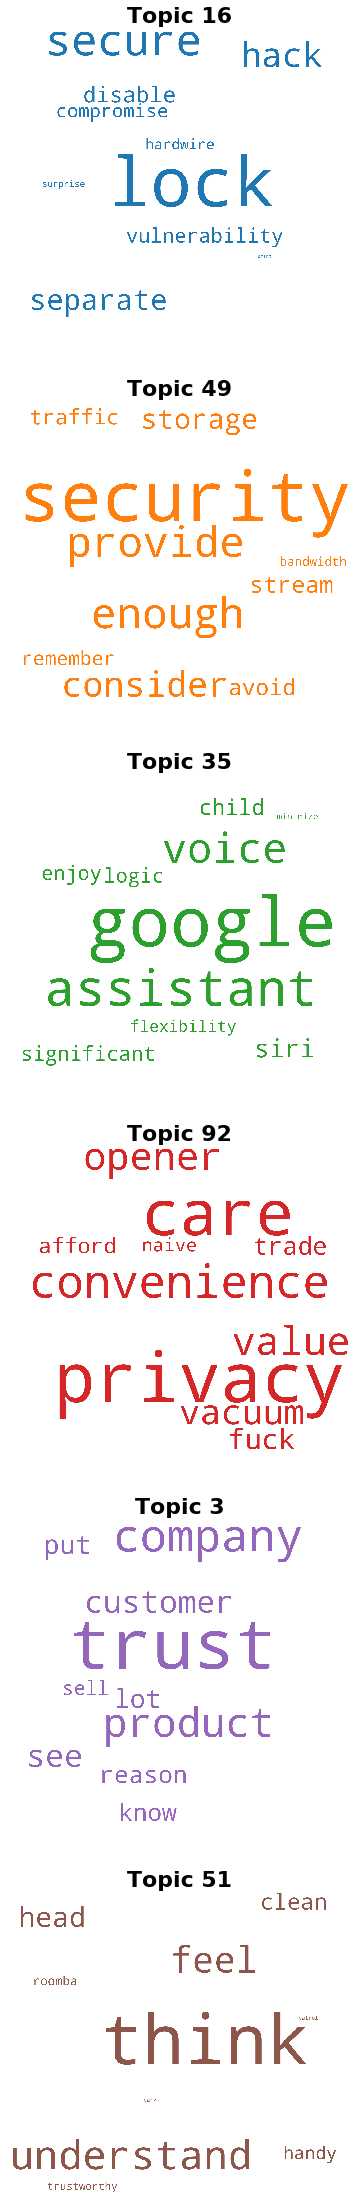

In [617]:
# Word coluds of Top N Keywords in Each Topic
# with the size of the words proportional to the weight
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2000,
                  height=1800,
                  max_words=50,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = []
for i in target_topics:
    topics.append((i, model.show_topic(i, topn=10)))


fig, axes = plt.subplots(len(target_topics), 1, figsize=(40,40), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=400)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(target_topics[i]), fontdict=dict(size=22, weight = 'bold'))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0.2, hspace=0.2)
plt.margins(x=0, y=0)
#plt.tight_layout()
plt.show()